In [1]:
import numpy as np
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.style.use('ggplot')
plt.rc('font', size=12)

***
# Cодержание
* [Реализация *k-means*](#impl)
* [Генерация базовых данных](#base)
* [Запуск без настроек](#run)
* [Значимость инициализации центров](#smart)
* [Оценка качества кластеризации](#eval)
* [Определение числа кластеров](#clcnt)
    * [Функционалы для определения числа кластеров](#sad)
    * [Силуэты](#sils)
* [Применимость *k-means*](#baddata)
* [Оптимизация кода](#opt)
* [Вместо заключения](#elka)
***

<a id='impl'></a>
# Реализация *k-means*

In [2]:
from copy import copy
from numpy.linalg import norm


class MyKmeans:
    eps = 1e-5
    max_depth = 100
    
    def __init__(self, n_clusters=2, init_method='random', 
                 random_seed=0, n_runs=1, assess='I'):
        self.centers = None
        self.labels = None
        self.n_clusters = n_clusters
        self.init = init_method
        self.n_runs = n_runs
        self.eval = -1
        self.assess = eval_dct[assess]
        self.seed = random_seed
        self.n_iters = 0
    
    def __copy__(self):
        nobj = MyKmeans()
        nobj.__dict__.update(self.__dict__)
        return nobj
    
    def _clust_once(self, X):
        self._centroids_init(X)
        next_centroids = np.empty_like(self.centers)
        self.n_iters = 0
        d = 1
        while d > self.eps and self.n_iters < self.max_depth:
            self.labels = norm(X - self.centers[:, np.newaxis], axis=2).argmin(axis=0)
            for j in range(self.n_clusters):
                next_centroids[j] = X[self.labels == j].mean(axis=0)
            d = np.sum(abs(self.centers - next_centroids))
            self.centers = np.copy(next_centroids)
            self.n_iters += 1
        self.assess(self, X)
        
    def _centroids_init(self, X):
        if self.init == 'random':
            indices = np.random.choice(len(X), self.n_clusters, replace=False)
            self.centers = X[indices]
        elif self.init == 'smart':
            indices = np.empty(self.n_clusters, dtype=np.int)
            indices[0] = np.random.randint(0, len(X))
            for i in range(1, self.n_clusters):
                indices[i] = norm((X - X[indices[:i]][:, np.newaxis]), axis=2).min(axis=0).argmax()
            self.centers = X[indices]
    
    def clusterize(self, X, show=False):
        np.random.seed(self.seed)
        self._clust_once(X)
        if self.n_runs == 1:
            return self
        best = copy(self)
        for _ in range(self.n_runs - 1):
            self._clust_once(X)
            if self.eval < best.eval:
                best = copy(self)
        self.__dict__.update(best.__dict__)
        return self
    
    def show(self, X, centroids=True, n_iters=False):
        plt.scatter(X[:, 0], X[:, 1], c=self.labels, s=70, cmap='Greens',
                edgecolors='black', linewidth=1.0)
        if centroids:
            plt.scatter(self.centers[:, 0], self.centers[:, 1], marker='X',
                        color='#FF0077', edgecolors='white', lw=2, s=250)
        if n_iters:
            plt.xlabel(f'{self.n_iters} итераций')
        plt.yticks(np.arange(-15, 16, 5))
        plt.xticks(np.arange(-15, 16, 5))
        tick_hide()
        plt.grid(lw=2)
        plt.xlim([-15, 15])
        plt.ylim([-15, 15])
        
    def dist_visual(self, X):
        arranged = X[np.argsort(self.labels)]
        D = (arranged[:, 0][:, np.newaxis] - arranged[:, 0]) ** 2
        D += (arranged[:, 1][:, np.newaxis] - arranged[:, 1]) ** 2
        D = np.sqrt(D)
        plt.imshow(D, cmap='Purples_r', aspect='auto')
        plt.xticks([])
        plt.yticks([])
        plt.colorbar(orientation='vertical', pad=0.06)
    
    def external(self):
        if self.n_clusters == 1:
            return 1
        c = self.centers
        return norm(c - c[:, np.newaxis], axis=2)[np.triu_indices(len(c), 1)].mean()
    
    def internal(self, X):
        qual = 0
        labs = self.labels
        for j in range(self.n_clusters):
            qual += norm(X[labs == j] - self.centers[j], axis=1).sum() / (labs == j).sum()
        self.eval = qual
    
    def inertia(self, X):
        qual = 0
        for j in range(self.n_clusters):
            qual += ((X[self.labels == j] - self.centers[j]) ** 2).sum()
        self.eval = qual

    def ext_internal(self, X):
        self.internal(X)
        self.eval /= self.external()
    
    def ext_inertia(self, X):
        self.inertia(X)
        self.eval /= self.external()
        
eval_dct = {'F': MyKmeans.internal, 'I': MyKmeans.inertia, 
        'FB': MyKmeans.ext_internal, 'IB': MyKmeans.ext_inertia}

<a id='base'></a>
## Генерация базовых данных

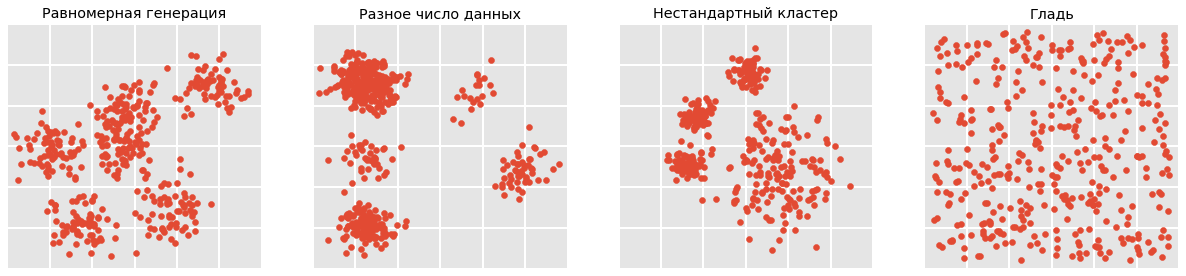

In [3]:
import sklearn.datasets as dsets
np.random.seed(0)
n_samples = 400
pure_blobs, _ = dsets.make_blobs(n_samples=n_samples, n_features=2,
                                 centers=6, random_state=11, cluster_std=1.9)
difsized_blobs, _ = dsets.make_blobs(n_samples=n_samples, n_features=2,
                                     centers=5, random_state=23, cluster_std=[1, 3.4, 1, 1, 3.4])
difcnt_blobs, dc_l = dsets.make_blobs(n_samples= 2 * n_samples, n_features=2, 
                                      centers=6, random_state=42222, cluster_std=1.5)
difcnt_blobs = np.vstack((difcnt_blobs[dc_l == 0][:], 
                          difcnt_blobs[dc_l == 1][:],
                          difcnt_blobs[dc_l == 2][:50],
                          difcnt_blobs[dc_l == 3][:20],
                          difcnt_blobs[dc_l == 4][:],
                          difcnt_blobs[dc_l == 5][:40]))
canvas = (np.random.rand(n_samples, 2) - 0.5) * 28

def tick_hide():
    plt.tick_params(labelleft=False, labelbottom=False, bottom=False, left=False)

def show_ds(X):
    plt.yticks(np.arange(-15, 16, 5))
    plt.xticks(np.arange(-15, 16, 5))
    tick_hide()
    plt.grid(lw=2)
    plt.xlim([-15, 15])
    plt.ylim([-15, 15])
    plt.scatter(X[:, 0], X[:, 1])

plt.figure(figsize=(21, 4.5))
plt.subplot(141)
plt.title('Равномерная генерация')
show_ds(pure_blobs)
plt.subplot(142)
plt.title('Разное число данных')
show_ds(difcnt_blobs)
plt.subplot(143)
plt.title('Нестандартный кластер')
show_ds(difsized_blobs)
plt.subplot(144)
plt.title('Гладь')
show_ds(canvas)

<a id='run'></a>
# Запуск без настроек

Попробуем применить к сгенерированным данным простейший вариант *kmeans*, самостоятельно задавая число кластеров и случайным образом инициализируя центры. Быстро ли сойдется алгоритм?

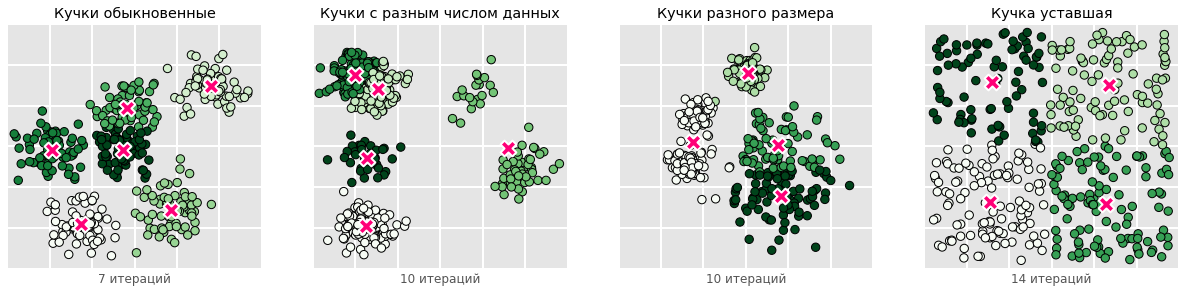

In [4]:
seed = 1
plt.figure(figsize=(21, 4.5))

plt.subplot(141)
plt.title('Кучки обыкновенные')
kmobj = MyKmeans(n_clusters=6, random_seed=seed).clusterize(pure_blobs)
kmobj.show(pure_blobs, n_iters=True)

plt.subplot(142)
plt.title('Кучки с разным числом данных')
kmobj = MyKmeans(n_clusters=5, random_seed=seed).clusterize(difcnt_blobs)
kmobj.show(difcnt_blobs, n_iters=True)

plt.subplot(143)
plt.title('Кучки разного размера')
kmobj = MyKmeans(n_clusters=4, random_seed=seed).clusterize(difsized_blobs)
kmobj.show(difsized_blobs, n_iters=True)

plt.subplot(144)
plt.title('Кучка уставшая')
kmobj = MyKmeans(n_clusters=4, random_seed=seed).clusterize(canvas)
kmobj.show(canvas, n_iters=True)

Заметим, что алгоритм работает. Однако результат на втором и третьем наборах не совпадает с ожидаемым. Попробуем улучшить точность, а также сократить число шагов до сходимости.

__Эвристика первая__ $-$ более осмысленная инициализация центроидов: первый центр выберем случайно, а каждый следующий будет выбираться так, чтобы расстояние от него до ближайшей помеченного объекта-центра было максимально.

<a id='smart'></a>
# Значимость инициализации центров

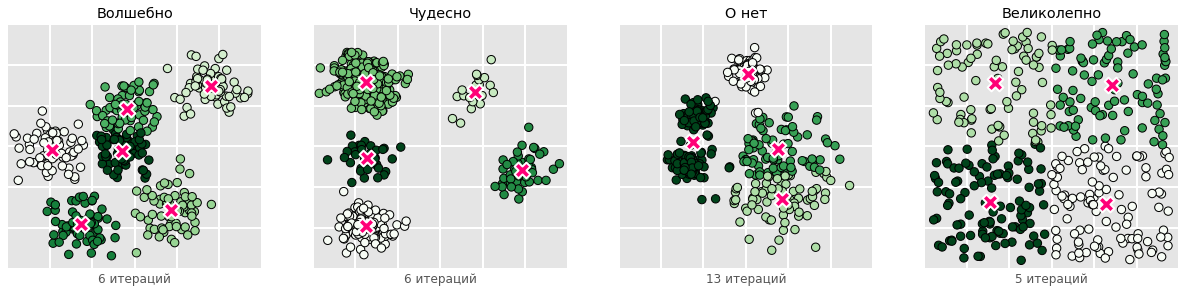

In [5]:
plt.figure(figsize=(21, 4.5))
plt.subplot(141)
plt.title('Волшебно')
kmobj = MyKmeans(n_clusters=6, random_seed=seed, init_method='smart').clusterize(pure_blobs)
kmobj.show(pure_blobs, n_iters=True)

plt.subplot(142)
plt.title('Чудесно')
kmobj = MyKmeans(n_clusters=5, random_seed=seed, init_method='smart').clusterize(difcnt_blobs)
kmobj.show(difcnt_blobs, n_iters=True)

plt.subplot(143)
plt.title('О нет')
kmobj = MyKmeans(n_clusters=4, random_seed=seed, init_method='smart').clusterize(difsized_blobs)
kmobj.show(difsized_blobs, n_iters=True)

plt.subplot(144)
plt.title('Великолепно')
kmobj = MyKmeans(n_clusters=4, random_seed=seed, init_method='smart').clusterize(canvas)
kmobj.show(canvas, n_iters=True)

Ну вот, алгоритм сходится быстрее, и кластеризация на 2-м наборе стала качественней! Только на 3-м наборе результат оказался еще хуже, чем был... А что призойдет, если удачно изменить сид?

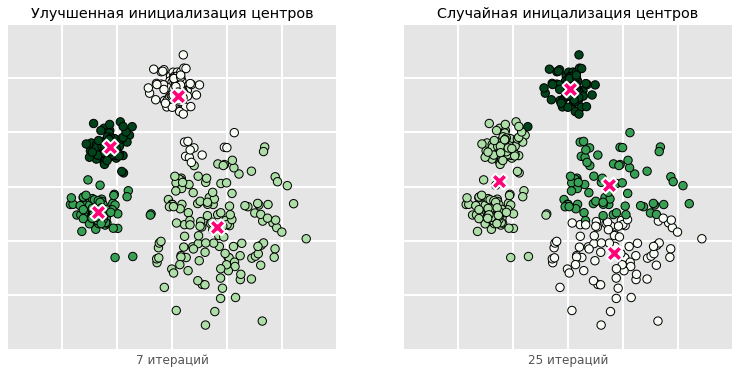

In [6]:
plt.figure(figsize=(13, 6))

another_seed = 18

plt.subplot(121)
plt.title('Улучшенная инициализация центров')
kmobj = MyKmeans(n_clusters=4, random_seed=another_seed,
                 init_method='smart').clusterize(difsized_blobs)
kmobj.show(difsized_blobs, n_iters=True)

plt.subplot(122)
plt.title('Случайная иницализация центров')
kmobj = MyKmeans(n_clusters=4, random_seed=another_seed,
                 init_method='random').clusterize(difsized_blobs)
kmobj.show(difsized_blobs, n_iters=True)

In [7]:
%timeit MyKmeans(n_clusters=4, random_seed=another_seed, init_method='random').clusterize(difsized_blobs)
%timeit MyKmeans(n_clusters=4, random_seed=another_seed, init_method='smart').clusterize(difsized_blobs)

3.51 ms ± 24.9 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
1.17 ms ± 9.71 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


Совсем другое дело!

А сейчас не самый радостный вывод: *k-means* весьма чувствителен к иницализации центров. Хотя этот факт тоже можно использовать $-$ __эвристика вторая__: будем применять алгоритм несколько раз, возвращая наиболее качественную кластеризацию *(n_runs)*. Осталось понять, как измерить качество.

<a id='eval'></a>
# Оценка качества кластеризации

Объекты из одного кластера должны быть похожими, то есть *близкими*, а объекты из разных кластеров $-$ *отдаленными*. В качестве метрики будем использовать евклидову. 

Требуется минимизировать расстояние между объектами одного кластера. Почему бы не воспользоваться особенностью *k-means* $-$ нам известны центроиды:
$$F=\sum_{k=1}^{n}\frac{1}{|C_k|}\sum_{x\in C_k}\rho(x,\mu_k)\ \longrightarrow\ min$$
С другой стороны, можно не нормировать внутрикластерные суммы. Если при этом использовать квадраты расстояний, то функционал станет более чувствительным к отдаленным объектам:
$$I=\sum_{x\in X} \rho^2 (x,\mu(x))\ \longrightarrow\ min$$
Отметим, что данная величина используется в реализации *scikit-learn* (там она названа *inertia* $-$ по-видимому, из-за сходства с формулой момента инерции).

Введенные выше функционалы должны расправиться с внутрикластерными расстояниями, но ведь еще мы хотим сделать большими межкластерные расстояния. Рассчитаем среднее межкластерное расстояние:
$$B=\frac{\sum_{\mu_i\ne\mu_j}\rho(\mu_i,\mu_j)}{|\mathcal{M}|}\ \longrightarrow\ max$$


где $|\mathcal{M}|$ $-$ мощность множества центров (количество кластеров).
Введем отношения: $$F_B=\frac{F}{B}\rightarrow min, I_B=\frac{I}{B}\rightarrow\min$$

В исходном коде функционалы занесены в словарь *eval_dct* и выбираются с помощью параметра *assess* (имеет смысл при *n_runs* > 1).

<a id='clcnt'></a>
# Стратегии выбора числа кластеров
<a id='sad'></a>
## Функционалы для определения числа кластеров

Рассмотрим задачу о выборе числа кластеров, исследуя, как оно отразится на функционалах $F,\ I,\ F_B,\ I_B$.
Возьмем еще один набор данных с большим числом возможных кластеров.

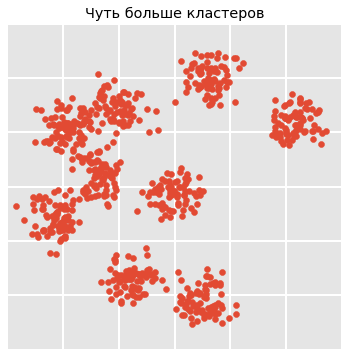

In [8]:
more_blobs, _ = dsets.make_blobs(n_samples=700, n_features=2, centers=9, random_state=800)
more_blobs *= 1.25
plt.figure(figsize=(6, 6))
plt.title('Чуть больше кластеров')
show_ds(more_blobs)

In [9]:
def judge(X, func, count=20):
    quals = np.empty(count, dtype=np.float64)
    for i in range(count):
        pam = MyKmeans(n_clusters=i+2, assess=func, random_seed=seed,
                       init_method='smart', n_runs=10).clusterize(X)
        quals[i] = pam.eval
    return quals

qual_dct = dict()
for func in eval_dct.keys():
    qual_dct[func] = judge(more_blobs, func)

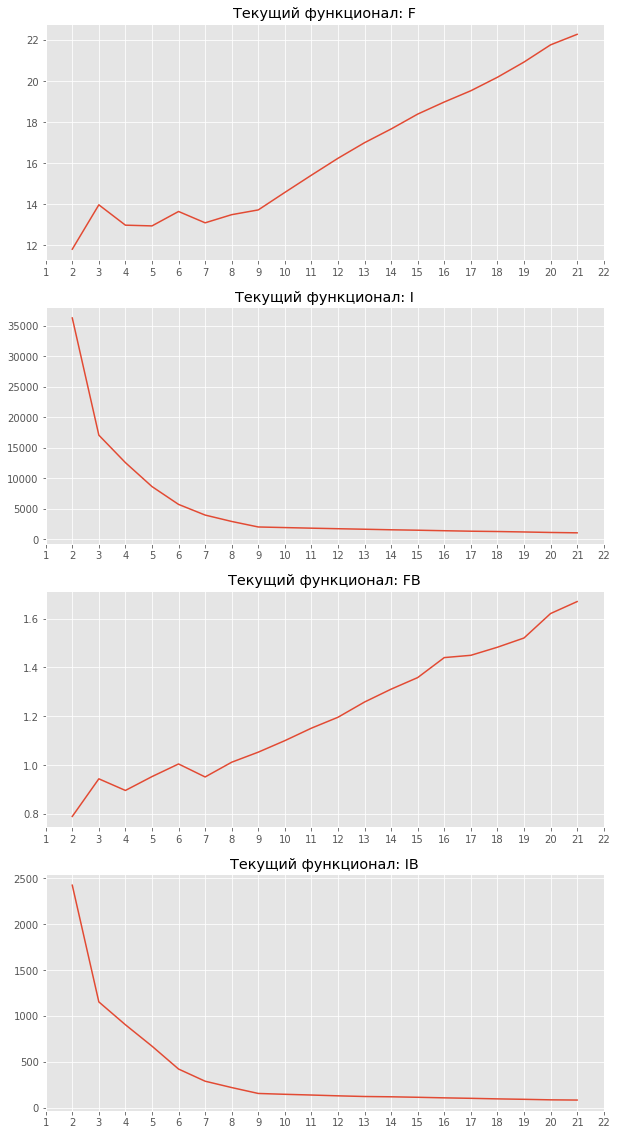

In [10]:
def show_gr(quals):
    plt.xticks(np.arange(len(quals) + 2) + 1)
    plt.xlim([1, len(quals) + 2])
    plt.plot(np.arange(len(quals)) + 2, quals)

plt.figure(figsize=(10, 20))

print(enumerate(qual_dct))

for i, func in enumerate(qual_dct):
    plt.subplot(4, 1, i + 1)
    plt.title(f'Текущий функционал: {func}')
    show_gr(qual_dct[func])

Как видим, функционал $F$ в данной форме не применим для задачи о выборе числа кластеров. Почему?

На самом деле с ростом $n$ увеличивается число слагаемых, а мощности отдельных кластеров $-$ падают. 
Таким образом, использование $F$ оправдано лишь при __фиксированном__ числе кластеров: в данной реализации можно его указать в качестве оценки лучшей кластеризации (вторая эвристика).

Учитывание среднего межкластерного расстояния тоже не дало ожидаемого результата для наших данных.
Зато стало понятно, как для определения числа кластеров использовать $I$: нам следует искать точку, на которой качество перестает заметно меняться:
$$N=argmin\frac{I(n)-I(n+1)}{I(n-1)-I(n)}$$

<a id='sils'></a>
## Силуэты

Продолжая решать задачу о выборе числа кластеров, реализуем и применим к имеющимся выборкам [метод силуэтов](https://www.sciencedirect.com/science/article/pii/0377042787901257).

Для каждого объекта $x$ определим два параметра.
Один будет показывать, насколько точка в среднем близка к другим объектам из своего кластера $C_k$:
$$a(x)=\frac{\sum_{y \in C_k}\rho(y,x)}{|C_k|-1}$$
Другой показатель определит среднее расстояние до объектов соседнего кластера:
$$b(x)=\min_{i \ne k}\frac{\sum_{y \in C_i}\rho(y,x)}{|C_k|}$$
Силуэтом называется величина:
$$s(x)=\frac{b(x)-a(x)}{max\{a(x),b(x)\}},$$
принимающая значения из $[-1, 1]$ и показывающая, как хорошо объект подходит своему текущему кластеру. (При неопределенностях с делением на ноль полагаем $s(x)=0$). В качестве оценки всей кластеризации возьмем средний силуэт.

In [11]:
def silhouette(X, labels, n_clusters):
    sil_sum = 0
    def neighbor_dist_avg(j):
        if j == lab:
            return np.finfo(np.float64).max
        else:
            return norm(X[labels == j] - p, axis=1).sum() / (labels == j).sum()
    vmd = np.vectorize(neighbor_dist_avg)
    for p, lab in zip(X, labels):
        if (labels == lab).sum() > 1:
            a = norm(X[labels == lab] - p, axis=1).sum() / ((labels == lab).sum() - 1)
            b = vmd(np.arange(n_clusters)).min()
            sil_sum += (b - a) / max(a, b)
    return sil_sum / len(X)

def sil_select(X, bound=25):
    ns = np.arange(2, bound)
    sils = np.empty(len(ns), dtype=np.float64)
    for n in ns:
        labels = MyKmeans(n_clusters=n, random_seed=seed, init_method='smart')\
                .clusterize(X).labels
        sils[n - 2] = silhouette(X, labels, n)
    return ns, sils

Протестируем теперь на наших наборах, визуализируя результат *k-means* в точках максимума.

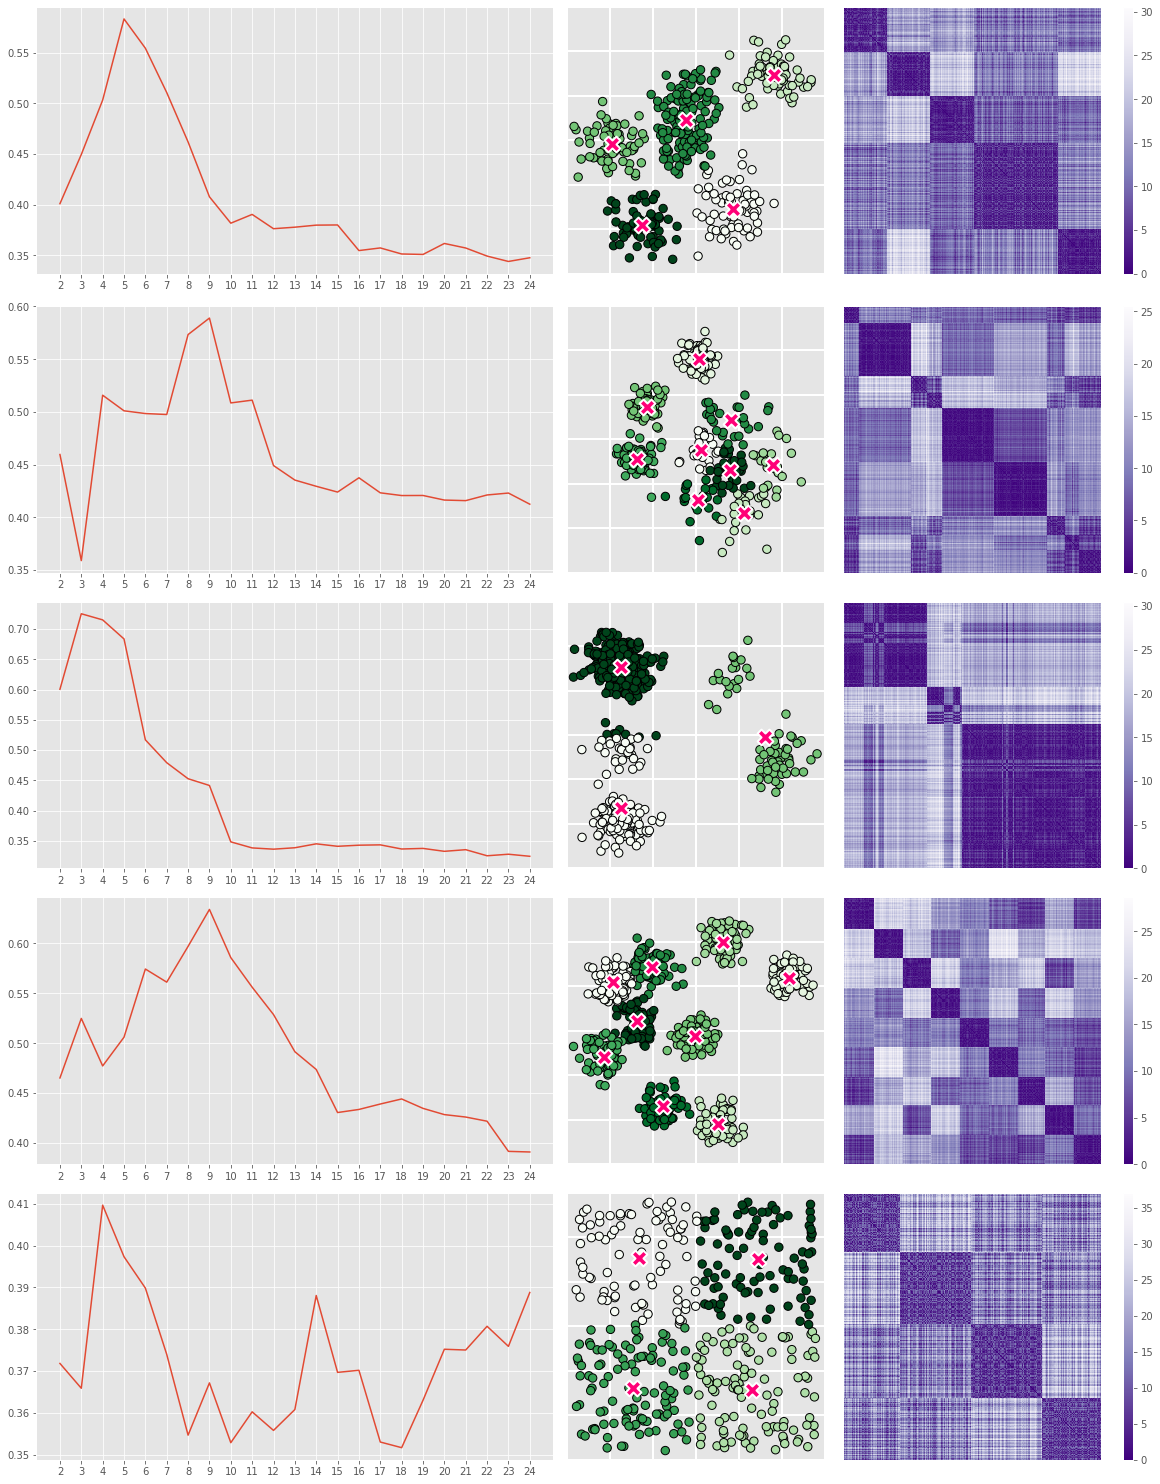

In [12]:
sets = [pure_blobs, difsized_blobs, difcnt_blobs, more_blobs, canvas]
board = plt.figure(constrained_layout=True, figsize=(16, 20.5))

widths = [6, 3, 3]
heights = [1] * 5
gs = board.add_gridspec(ncols=3, nrows=5, width_ratios=widths,
                          height_ratios=heights)
for row, X in enumerate(sets):
    ns, sils = sil_select(X)
    n = ns[sils.argmax()]
    kmobj = MyKmeans(n_clusters=n, random_seed=seed, n_runs=10, 
                     init_method='smart').clusterize(X)
    ax = board.add_subplot(gs[row, 0])
    plt.xticks(ns)
    plt.plot(ns, sils)
    ax = board.add_subplot(gs[row, 1])
    kmobj.show(X)
    ax = board.add_subplot(gs[row, 2])
    kmobj.dist_visual(X)

Как и следовало ожидать, метод силуэтов сработал хорошо на "удобных" данных. Из примеров видна его проблема: он чувствителен к неравномерному числу элементов в кластерах, а также к кластерам с разной дисперсией. Однако сам *k-means* не очень-то любит такие наборы. Тогда для каких данных следует (не)использовать *k-means*? 

<a id='baddata'></a>
# Применимость *k-means*

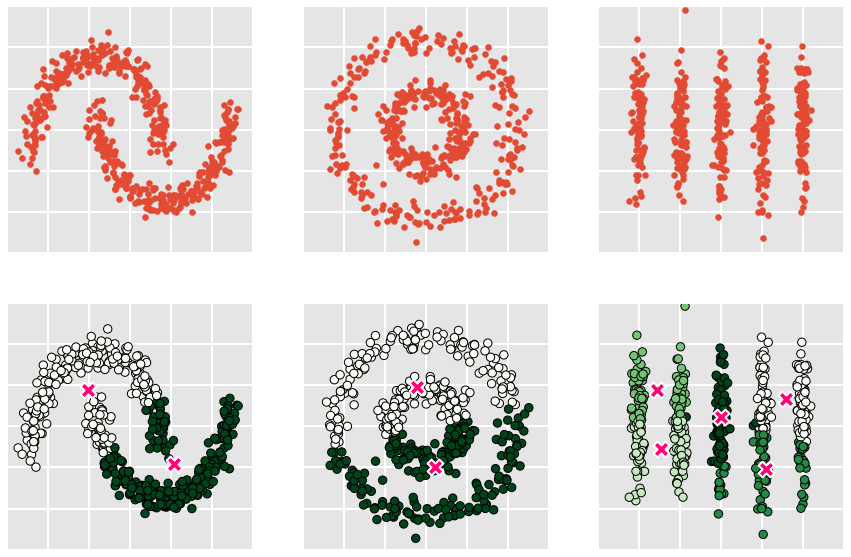

In [13]:
n_samples = 500
noise = 0.08
moons, _ = dsets.make_moons(n_samples=n_samples, random_state=seed, noise=noise)
moons = moons * [8, 12] - [4, 3]
circles, _ = dsets.make_circles(n_samples=n_samples, factor=0.4,
                                random_state=seed, noise=noise)
circles *= 11
sticks_centers = [[0, 0], [5, 0], [-5, 0], [10, 0], [-10, 0]]
sticks, _ = dsets.make_blobs(n_samples=n_samples, centers=sticks_centers,
                                random_state=3, cluster_std=0.4)
sticks *= [1, 11]

bad_ds = [[moons, 2], [circles, 2], [sticks, 5]]

plt.figure(figsize=(15, 10))
for col, kit in enumerate(bad_ds):
    X, n_clusters = kit
    plt.subplot(2, 3, col + 1)
    show_ds(X)
    plt.subplot(2, 3, col + 4)
    kmobj = MyKmeans(n_clusters=n_clusters, init_method='smart',
                     n_runs=10, random_seed=seed).clusterize(X)
    kmobj.show(X)

Как видим, хотя *k-means* не сложен в реализации, назвать его универсальным алогритмом нельзя.

Он отлично справляется с набором похожих кучек. Строже говоря, лучшие данные для *k-means* $-$ совокупность кластеров, которые можно ограничить непересекающимися* шарами (в пространстве соответствующей размерности) с одинаковыми* радиусами и одинаковым* числом точек в этих шарах $-$ иначе окрестности выбранных центров не будут хорошо описывать кластеры. При не столь выраженных отклонениях от этих жестких условий со звездочкой *k-means* все еще может давать неплохой результат (особенно с апгрейдами наподобие вышереализованных эвристик).

Вообще, многие особенности могут сделать *k-means* непригодным: взаимные перекрытия кластеров, нетривиальные структуры, соединения, наличие объектов вне кластеров.

Более того, предполагались лишь данные с вещественными, а не категориальными признаками.

<a id='opt'></a>
# Оптимизация кода
Встроенные операции *numpy*, индексация с использованием логических массивов и *broadcasting* дают немалый выигрыш в эффективности и красоте кода!

Например, $i$-й центр в улучшенной инициализации можно находить так:
```Python
indices[i] = norm((X - X[indices[:i]][:, np.newaxis]), axis=2).min(axis=0).argmax()```

Одна итерация *k-means* : 
```Python
self.labels = norm(X - self.centers[:, np.newaxis], axis=2).argmin(axis=0) # assignment
for j in range(self.n_clusters):
    next_centroids[j] = X[self.labels == j].mean(axis=0) # update```

Среднее расстояние между центрами кластеров:
```Python
norm(c - c[:, np.newaxis], axis=2)[np.triu_indices(len(c), 1)].mean()```

В методе силуэтов была векторизована функция поиска среднего расстояния до точек другого кластера, однако нельзя говорить об особой эффективности вычислений, поскольку остался цикл по всем объектам совокупности.

<a id='elka'></a> 
# Вместо заключения

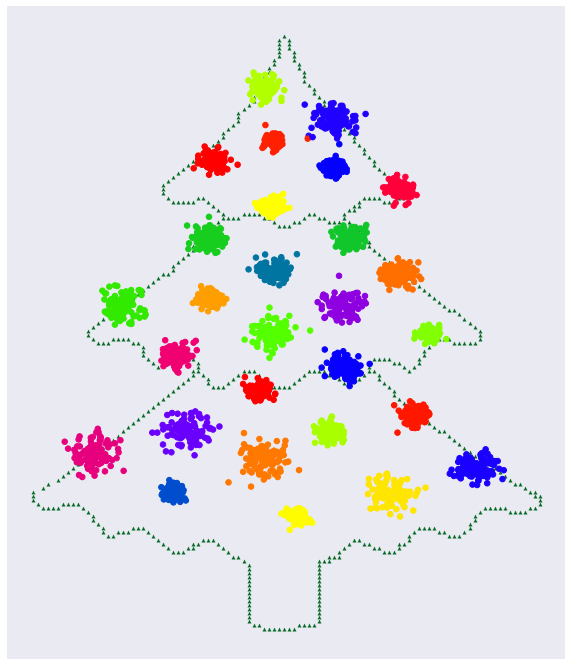

In [14]:
dt = np.genfromtxt('very_serious_dataset.csv', delimiter=';')
tree = dt[:, :2]
b = dt[:, 2:]
b = b[~np.isnan(b)].reshape(-1, 2)
np.random.seed(seed)
stds = np.random.rand(len(b)) * 1.5 + 1
balls, _ = dsets.make_blobs(n_samples=3000, centers=b, cluster_std=stds)

labels = MyKmeans(n_clusters=len(b), init_method='smart',
                  n_runs=10).clusterize(balls).labels

mpl.style.use('seaborn')
plt.figure(figsize=(10, 12))
tick_hide()
plt.xticks([])
plt.yticks([])
plt.scatter(tree[:, 0], tree[:, 1], c='#046627', s=20, marker='^', edgecolors='white')
plt.scatter(balls[:, 0], balls[:, 1], c=labels, cmap='prism', s=30, lw=1,  marker='o')